# Additional Question 1
### How to handle cases where the test food images do not belong to any of the 5 target food categories 

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm

## Method 1 
#### - Evaluate confidence value of predicted class
        - Assume that the model will have lower confidence value when predicting images that do not belong to the 5 target food categories
#### - Evaluate entropy of CNN prediction probabilites
        - Entropy measures the randomness of a data
        - Assume that the model prediction probabilities will have high entropy when predicting images that do not belong to the 5 target food categories

In [2]:
def get_model(model_name, model_path, num_classes):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(2048, num_classes)
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [3]:
class FoodDataset(Dataset):
    def __init__(self, file, transform=None, mode="train"):
        self.transforms = transform
        self.mode = mode
        with open(file, "r") as f:
            self.image_list = f.readlines()

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        label = None
        img_path = self.image_list[index].split("\n")[0].split("\t")[0]
        if self.mode == "train":
            image, label = self.image_list[index].split("\n")[0].split("\t")
            label = int(label)
        else:
            image = self.image_list[index].split("\n")[0]
        image = Image.open(image).convert("RGB")
        image = self.transforms(image)
        if self.mode == "train":
            return img_path, image, label
        else:
            return image

In [4]:
transforms_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_ds = FoodDataset("./data/test.txt", transform=transforms_test)
others_ds = FoodDataset("./data/others.txt", transform=transforms_test)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 5
# model = get_model("resnet50", "checkpoint/resnet50/resnet50_final.pth", num_classes)
model = get_model("vgg16", "checkpoint/vgg16/vgg16_final.pth", num_classes)
model.to(device)

results = list()

def calculate_entropy(output):
    x = -output * output.log()
    return x.sum(dim=1)

for dataset in [test_ds, others_ds]:
    is_in = 1 if dataset == test_ds else 0
    for img_path, img, label in tqdm(dataset):
        with torch.no_grad():
            img = img.unsqueeze(0).to(device)
            lbl = torch.tensor(label).to(device)

            output = model(img)
            output = torch.nn.functional.softmax(output, dim=1)
            entropy = calculate_entropy(output)
            prediction = torch.argmax(output, dim=1)

            res = {
                "image_path": img_path,
                "is_in": is_in,
                "true": label,
                "predicted": prediction.item(),
                "predicted_class_conf": round(torch.max(output).item(), 5),
                "entropy": round(entropy.item(), 5)
            }
            results.append(res)

results = pd.DataFrame(results)
results

100%|██████████| 525/525 [00:05<00:00, 100.63it/s]


,image_path,is_in,true,predicted,predicted_class_conf,entropy
0,data/test/Bak Chor Mee/Bak Chor Mee(2052).jpg,1,0,0,0.58898,1.11236
1,data/test/Bak Chor Mee/Bak Chor Mee(483).jpg,1,0,0,0.89843,0.46889
2,data/test/Bak Chor Mee/Bak Chor Mee(893).jpg,1,0,0,0.89319,0.48777
3,data/test/Bak Chor Mee/Bak Chor Mee(2044).jpg,1,0,0,0.90250,0.45468
4,data/test/Bak Chor Mee/Bak Chor Mee(1064).jpg,1,0,0,0.84439,0.64348
...,...,...,...,...,...,...
1520,data/test/Nasi Lemak/Nasi Lemak(440).jpg,0,5,0,0.46793,1.31507
1521,data/test/Nasi Lemak/Nasi Lemak(597).jpg,0,5,4,0.92172,0.38156
1522,data/test/Nasi Lemak/Nasi Lemak(164).jpg,0,5,2,0.83133,0.68578
1523,data/test/Nasi Lemak/Nasi Lemak(1289).jpg,0,5,3,0.59148,1.19873


Text(0.5, 1.0, 'Box plot - Distribution of Entropy of Output')

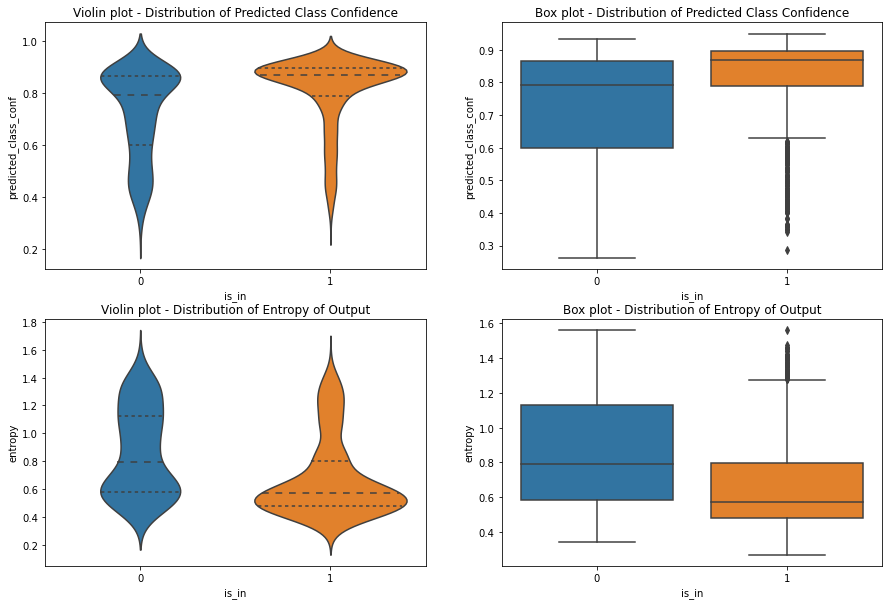

In [7]:
# vgg
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sb.set_palette("tab10")
sb.violinplot(data=results, x="is_in", y="predicted_class_conf", scale="count", inner="quartile", ax=ax[0][0])
sb.boxplot(data=results, x="is_in", y="predicted_class_conf", ax=ax[0][1])
sb.violinplot(data=results, x="is_in", y="entropy", scale="count", inner="quartile", ax=ax[1][0])
sb.boxplot(data=results, x="is_in", y="entropy", ax=ax[1][1])

ax[0][0].set_title("Violin plot - Distribution of Predicted Class Confidence")
ax[0][1].set_title("Box plot - Distribution of Predicted Class Confidence")
ax[1][0].set_title("Violin plot - Distribution of Entropy of Output")
ax[1][1].set_title("Box plot - Distribution of Entropy of Output")

In [8]:
target_class_predicted_correctly = len(results.loc[(results["is_in"] == 1) & (results["true"] == results["predicted"])])
target_class_total = len(results.loc[results["is_in"] == 1])
print("Target class test accuracy: {} %".format(round(target_class_predicted_correctly / target_class_total * 100, 2)))

Target class test accuracy: 89.7 %


In [9]:
def get_confidence_threshold(percentile):
    return np.percentile(results[results["is_in"] == 1]["predicted_class_conf"], percentile)

conf_res = list()
for percentile in [10, 15, 20, 25, 30, 35, 40, 45, 50]:
    confidence_threshold = get_confidence_threshold(percentile)
    others_detected = len(results.loc[(results["is_in"] == 0) & (results["predicted_class_conf"] < confidence_threshold)])
    others_total = len(results.loc[results["is_in"] == 0])
    conf_res.append({
        "percentile": percentile,
        "% of target class falsely detected as others": percentile,
        "confidence threshold": confidence_threshold,
        "detection rate %": round(others_detected / others_total * 100, 2)
    })

conf_res = pd.DataFrame(conf_res)
conf_res

,percentile,% of target class falsely detected as others,confidence threshold,detection rate %
0,10,10,0.568061,22.29
1,15,15,0.661264,32.57
2,20,20,0.747676,44.19
3,25,25,0.787725,49.52
4,30,30,0.818306,55.05
5,35,35,0.842419,63.43
6,40,40,0.852012,67.62
7,45,45,0.861109,72.95
8,50,50,0.867875,77.90


In [10]:
def get_entropy_threshold(percentile):
    return np.percentile(results[results["is_in"] == 1]["entropy"], percentile)

entropy_res = list()
for percentile in [50, 55, 60, 65, 70, 75, 80, 85, 90]:
    entropy_threshold = get_entropy_threshold(percentile)
    others_detected = len(results.loc[(results["is_in"] == 0) & (results["entropy"] > entropy_threshold)])
    others_total = len(results.loc[results["is_in"] == 0])
    entropy_res.append({
        "percentile": percentile,
        "% of target class falsely detected as others": 100 - percentile,
        "entropy threshold": entropy_threshold,
        "detection rate %": round(others_detected / others_total * 100, 2)
    })

entropy_res = pd.DataFrame(entropy_res)
entropy_res

,percentile,% of target class falsely detected as others,entropy threshold,detection rate %
0,50,50,0.571945,77.52
1,55,45,0.593101,72.76
2,60,40,0.622422,67.43
3,65,35,0.651998,63.43
4,70,30,0.710737,55.62
5,75,25,0.799057,49.52
6,80,20,0.878748,44.19
7,85,15,1.055033,32.57
8,90,10,1.185378,20.57


## Method 2

### Add a new class which include the images from other classes and train a new model

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 6
model = get_model("vgg16", "checkpoint/vgg16-6/vgg16_final.pth", num_classes)
model.to(device)

results = list()

for dataset in [test_ds, others_ds]:
    is_in = 1 if dataset == test_ds else 0
    for img_path, img, label in tqdm(dataset):
        with torch.no_grad():
            img = img.unsqueeze(0).to(device)
            lbl = torch.tensor(label).to(device)

            output = model(img)
            prediction = torch.argmax(output, dim=1)

            res = {
                "image_path": img_path,
                "is_in": is_in,
                "true": label,
                "predicted": prediction.item(),
            }
            results.append(res)

results = pd.DataFrame(results)
results

100%|██████████| 525/525 [00:04<00:00, 127.28it/s]


,image_path,is_in,true,predicted
0,data/test/Bak Chor Mee/Bak Chor Mee(2052).jpg,1,0,0
1,data/test/Bak Chor Mee/Bak Chor Mee(483).jpg,1,0,0
2,data/test/Bak Chor Mee/Bak Chor Mee(893).jpg,1,0,0
3,data/test/Bak Chor Mee/Bak Chor Mee(2044).jpg,1,0,0
4,data/test/Bak Chor Mee/Bak Chor Mee(1064).jpg,1,0,0
...,...,...,...,...
1520,data/test/Nasi Lemak/Nasi Lemak(440).jpg,0,5,0
1521,data/test/Nasi Lemak/Nasi Lemak(597).jpg,0,5,5
1522,data/test/Nasi Lemak/Nasi Lemak(164).jpg,0,5,5
1523,data/test/Nasi Lemak/Nasi Lemak(1289).jpg,0,5,5


In [13]:
target_class_predicted_correctly = len(results.loc[(results["is_in"] == 1) & (results["true"] == results["predicted"])])
target_class_total = len(results.loc[results["is_in"] == 1])
print("Target class test accuracy: {} %".format(round(target_class_predicted_correctly / target_class_total * 100, 2)))

Target class test accuracy: 84.8 %


In [14]:
target_class_predicted_as_others = len(results.loc[(results["is_in"] == 1) & (results["predicted"] == 5)])
target_class_total = len(results.loc[results["is_in"] == 1])
print("% target class falsely detected as others: {} %".format(round(target_class_predicted_as_others / target_class_total * 100, 2)))

% target class falsely detected as others: 7.2 %


In [15]:
other_class_predicted_correctly = len(results.loc[(results["is_in"] == 0) & (results["true"] == results["predicted"])])
other_class_total = len(results.loc[results["is_in"] == 0])
print("% others correctly detected as others: {} %".format(round(other_class_predicted_correctly / other_class_total * 100, 2)))

% others correctly detected as others: 70.67 %
